### installing libraries

In [1]:
#!pip install geopandas

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import os

from io import StringIO


import zipfile
import geopandas as gpd

import gzip
import shutil

from shapely.geometry import Point
import geopandas as gpd

from sklearn.neighbors import KDTree
import ast

import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from collections import Counter

## defining data sources

To reduce resource exhaustion, some transformations are performed on datasets immediately after they are loaded, before they are merged. This helps reduce the dimensionality of the data.

### function for accessing csv's through http requests

In [3]:
#returns csv as string
def fetch_csv_from_http(url):
    response = requests.get(url)
    if response.status_code == 200:
        csv_data = StringIO(response.text)
    else:
        return "fetch failed"
    return csv_data

### downloading the points of interest dataset

In [4]:
poi_url = "https://download.geofabrik.de/europe/austria-latest-free.shp.zip"
response = requests.get(poi_url)
with open("austria-latest-free.shp.zip", "wb") as file:
    file.write(response.content)

with zipfile.ZipFile("austria-latest-free.shp.zip", "r") as zip_ref:
    zip_ref.extractall("austria_shapefiles")

In [5]:
pois = gpd.read_file("austria_shapefiles/gis_osm_pois_free_1.shp")
print(pois.head())

     osm_id  code        fclass           name                   geometry
0  15079895  2006     telephone           None  POINT (16.28689 48.19691)
1  15079903  2501   supermarket       Eurospar  POINT (16.28767 48.19697)
2  15080180  2501   supermarket     Billa Plus  POINT (16.29891 48.19776)
3  15080251  2522   sports_shop  Sports Direct  POINT (16.28276 48.19288)
4  17310328  2701  tourist_info           None  POINT (13.49914 47.59028)


In [6]:
num_classes = pois["fclass"].nunique()
print(f"Number of different classes in a column 'fclass': {num_classes}")

Number of different classes in a column 'fclass': 139


As we are going to merge datasets and encode categorical variables, 139 different classes can lead to significantly high dimensions, that is why we will categorize them before merging and overall preprocessing and highlite most important classes from our opinion

In [7]:
poi_category_map = {
    'bakery': 'cafe_restaurant', 'restaurant': 'cafe_restaurant', 'cafe': 'cafe_restaurant',
    'fast_food': 'cafe_restaurant', 'bar': 'other', 'supermarket': 'supermarket',
    'vending_machine': 'other', 'beverages': 'other', 'food_court': 'cafe_restaurant',
    'pub': 'other',

    'doctors': 'other', 'dentist': 'other', 'clinic': 'other',
    'hospital': 'other', 'pharmacy': 'other', 'veterinary': 'other',
    'beauty_shop': 'other', 'hairdresser': 'other', 'optician': 'other',
    'laundry': 'other',

    'toy_shop': 'shops_and_retail', 'furniture_shop': 'other', 'clothes': 'shops_and_retail',
    'jeweller': 'shops_and_retail',
    'bookshop': 'shops_and_retail', 'gift_shop': 'shops_and_retail', 'stationery': 'other',
    'mobile_phone_shop': 'other', 'sports_shop': 'other', 'shoe_shop': 'shops_and_retail',
    'computer_shop': 'other', 'greengrocer': 'other', 'car_dealership': 'other',
    'department_store': 'other', 'outdoor_shop': 'other', 'car_wash': 'other',
    'car_rental': 'other', 'kiosk': 'other', 'bicycle_rental': 'other',

    'tourist_info': 'entertainment_leisure', 'artwork': 'entertainment_leisure', 'museum': 'entertainment_leisure',
    'theatre': 'entertainment_leisure', 'cinema': 'other', 'nightclub': 'other',
    'attraction': 'entertainment_leisure', 'sports_centre': 'other', 'park': 'park',
    'playground': 'other', 'community_centre': 'other', 'arts_centre': 'other',
    'library': 'other',
    'picnic_site': 'other', 'garden_centre': 'other', 'vending_parking': 'other',

    'waste_basket': 'other', 'camera_surveillance': 'other', 'police': 'other',
    'fire_station': 'other', 'toilet': 'other', 'public_building': 'other',
    'post_box': 'other', 'recycling': 'other', 'recycling_glass': 'other',
    'recycling_paper': 'other', 'recycling_metal': 'other', 'recycling_clothes': 'other',
    'recycling': 'other', 'post_office': 'other', 'town_hall': 'other',
    'shelter': 'other', 'ambulance': 'other', 'court': 'other',
    'prison': 'other',

    'school': 'education', 'kindergarten': 'education', 'university': 'education',
    'college': 'education', 'embassy': 'education',

    'atm': 'transport_and_infrastructure', 'telephone': 'other', 'bank': 'transport_and_infrastructure',
    'car_sharing': 'other', 'car_wash': 'other', 'vending_cigarette': 'other',
    'vending_any': 'other',

    'memorial': 'entertainment_leisure', 'bench': 'other',
    'post_box': 'other', 'wayside_cross': 'other', 'vending_cigarette': 'other',
    'vending_parking': 'other', 'stationery': 'other', 'car_wash': 'other',
}


In [8]:
pois['category'] = pois['fclass'].map(poi_category_map).fillna('other')

In [9]:
num_classes = pois["category"].nunique()
print(f"Number of different classes in a column 'fclass': {num_classes}")

Number of different classes in a column 'fclass': 8


### wienlinien datasets

In [10]:
haltestellen_url = "https://www.wienerlinien.at/ogd_realtime/doku/ogd/wienerlinien-ogd-haltestellen.csv"
haltestellen_data = fetch_csv_from_http(haltestellen_url)
haltestellen_df = pd.read_csv(haltestellen_data, sep=';')
haltestellen_df.head()

,DIVA,PlatformText,Municipality,MunicipalityID,Longitude,Latitude
0,60200001,Schrankenberggasse,Wien,49000001,48.173801,16.389807
1,60200002,Achengasse,Wien,49000001,48.284460,16.448925
2,60200003,Ada-Christen-Gasse,Wien,49000001,48.152830,16.386043
3,60200004,Adam-Betz-Gasse,Wien,49000001,48.215581,16.535469
4,60200005,Adamovichgasse,Wien,49000001,48.142664,16.338621


In [11]:
haltestellen_df.shape

(1819, 6)

In [12]:
len(haltestellen_df.DIVA.unique())

1819

### airbnb datasets

#### download and extract gz compressed dataset

In [13]:
def download_and_extract_csv_gz(url, compressed_file, extracted_file, folder_name):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    try:
        # Step 1: Download the compressed file
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(compressed_file, "wb") as f:
                shutil.copyfileobj(response.raw, f)
            print(f"Downloaded: {compressed_file}")
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")
            return None

        # Step 2: Detect file type and extract
        if zipfile.is_zipfile(compressed_file):
            print("Detected a ZIP file. Extracting...")
            with zipfile.ZipFile(compressed_file, 'r') as zip_ref:
                zip_ref.extractall(folder_name)  # Extract all files into the specified folder
                extracted_file = os.path.join(folder_name, zip_ref.namelist()[0])  # Path of the first extracted file
                print(f"Extracted to: {folder_name}")
        else:
            print("Detected a GZIP file. Extracting...")
            extracted_file = os.path.join(folder_name, extracted_file)
            with gzip.open(compressed_file, "rb") as f_in:
                with open(extracted_file, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Extracted to: {extracted_file}")

        # Step 3: Load the CSV into a pandas DataFrame
        data = pd.read_csv(extracted_file)
        print("CSV loaded successfully.")
        return data

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    finally:
        # Cleanup: Remove the compressed file to save space
        if os.path.exists(compressed_file):
            os.remove(compressed_file)

In [14]:
airbnb_listings_url = "https://data.insideairbnb.com/austria/vienna/vienna/2024-09-11/data/listings.csv.gz"
airbnb_calendar_url = "https://data.insideairbnb.com/austria/vienna/vienna/2024-09-11/data/calendar.csv.gz"
airbnb_neighbourhoods_url = "https://data.insideairbnb.com/austria/vienna/vienna/2024-09-11/visualisations/neighbourhoods.csv"

### airbnb listing dataset

In [15]:
airbnb_listings_df = download_and_extract_csv_gz(airbnb_listings_url, "listings.csv.gz", "listings.csv", "airbnb")
airbnb_listings_df.head(30)

Downloaded: listings.csv.gz
Detected a GZIP file. Extracting...
Extracted to: airbnb/listings.csv
CSV loaded successfully.


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,city scrape,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.69,NaN,t,3,3,0,0,2.38
1,40625,https://www.airbnb.com/rooms/40625,20240911015603,2024-09-11,city scrape,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.61,4.72,NaN,t,14,13,1,0,1.26
2,51287,https://www.airbnb.com/rooms/51287,20240911015603,2024-09-11,city scrape,little studio- next to citycenter- wifi- nice ...,small studio in new renovated old house and ve...,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.87,4.59,NaN,t,3,3,0,0,2.29
3,70637,https://www.airbnb.com/rooms/70637,20240911015603,2024-09-11,city scrape,Flat in the Center with Terrace,NaN,NaN,https://a0.muscache.com/pictures/925691/c8c1bd...,358842,...,4.76,4.81,4.72,NaN,f,3,1,2,0,0.71
4,78416,https://www.airbnb.com/rooms/78416,20240911015603,2024-09-11,city scrape,Nice Apartment in Vienna center,"Newly renovated modern, comfortable apartment ...",Stadthalle – Viennas largest event center is j...,https://a0.muscache.com/pictures/7b8ed252-4016...,421075,...,4.43,4.41,4.47,NaN,t,2,2,0,0,1.09
5,90247,https://www.airbnb.com/rooms/90247,20240911015603,2024-09-11,city scrape,Beautiful New Central Apartment,"2-room apartment /55 m2 on 1st floor, fully re...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,489611,...,4.87,4.82,4.81,NaN,t,2,0,2,0,4.74
6,109679,https://www.airbnb.com/rooms/109679,20240911015603,2024-09-11,city scrape,Near Palace Schönbrunn - Apt. 4,Studio apartment for 4 persons:<br />- Bunk be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/1982234/1fc34...,175131,...,4.91,4.64,4.81,NaN,t,14,13,1,0,0.94
7,114505,https://www.airbnb.com/rooms/114505,20240911015603,2024-09-11,city scrape,"Near Palace Schönbrunn, Apt. 5",Studio apartment for 4 persons:<br />- Bunk be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11536257/9065...,175131,...,4.96,4.71,4.80,NaN,f,14,13,1,0,0.77
8,121026,https://www.airbnb.com/rooms/121026,20240911015603,2024-09-11,city scrape,"Feels-Like-Home Apt with garage, balcony & aircon","Air-Conditioned! Comfortable, modern and styli...","Prater Park - one step away, Metro stations ""N...",https://a0.muscache.com/pictures/miso/Hosting-...,608240,...,4.98,4.82,4.88,NaN,f,2,2,0,0,2.66
9,729796,https://www.airbnb.com/rooms/729796,20240911015603,2024-09-11,previous scrape,Modern with 12qm balcony near Danube,Wifi code: On the door,"Hofer, Spar, bipa",https://a0.muscache.com/pictures/e1bf8d31-5319...,3793751,...,4.38,4.75,4.88,NaN,f,2,2,0,0,0.09


In [16]:
airbnb_listings_df.shape

(14396, 75)

In [17]:
len(airbnb_listings_df.id.unique())

14396

In [18]:
num_classes = airbnb_listings_df["amenities"].nunique()
print(f"Number of different amenities in a column 'amenities': {num_classes}")

Number of different amenities in a column 'amenities': 12765


Check for most popular amenties

In [19]:
airbnb_listings_df.loc[:, 'amenities'] = airbnb_listings_df['amenities'].apply(ast.literal_eval)

# Calculate the frequency of amenities in the training data
all_amenities = [amenity for amenities_list in airbnb_listings_df['amenities'] for amenity in amenities_list]
amenity_counts = Counter(all_amenities)

# We list the 4 most popular amenities
most_common_amenities = [amenity for amenity, count in amenity_counts.most_common(4)]
print(most_common_amenities)

# leave only top 4

def filter_amenities(amenities):
    return [amenity for amenity in amenities if amenity in most_common_amenities]

airbnb_listings_df.loc[:, 'amenities'] = airbnb_listings_df['amenities'].apply(filter_amenities)
airbnb_listings_df.loc[:,'amenities'] = airbnb_listings_df['amenities'].apply(lambda x: ', '.join(x))

['Kitchen', 'Wifi', 'Essentials', 'Hair dryer']


### airbnb calender dataset

In [20]:
airbnb_calendar_df = download_and_extract_csv_gz(airbnb_calendar_url, "calendar.csv.gz", "calendar.csv", "airbnb")
airbnb_calendar_df.head(20)

Downloaded: calendar.csv.gz
Detected a GZIP file. Extracting...
Extracted to: airbnb/calendar.csv
CSV loaded successfully.


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,275668,2024-09-11,f,$59.00,NaN,2,1125
1,275668,2024-09-12,f,$59.00,NaN,2,1125
2,275668,2024-09-13,f,$59.00,NaN,2,1125
3,275668,2024-09-14,f,$59.00,NaN,2,1125
4,275668,2024-09-15,f,$59.00,NaN,2,1125
5,275668,2024-09-16,f,$59.00,NaN,2,1125
6,275668,2024-09-17,f,$59.00,NaN,2,1125
7,275668,2024-09-18,f,$59.00,NaN,2,1125
8,275668,2024-09-19,f,$59.00,NaN,2,1125
9,275668,2024-09-20,f,$59.00,NaN,2,1125


### aggregated data from day to week

In [21]:
airbnb_calendar_df['qnt'] = 1 # to count the number of rented days
airbnb_calendar_df['date'] = pd.to_datetime(airbnb_calendar_df['date'])

airbnb_calendar_df['price'] = airbnb_calendar_df['price'].str.replace('[\$,]', '', regex=True).astype(float)

#airbnb_calendar_df['date'] = airbnb_calendar_df['date'].dt.to_period('W')
# counting only unavailable days as rented
airbnb_calendar_df = airbnb_calendar_df[airbnb_calendar_df['available'] == 'f']\
                                        .groupby(['listing_id',
                                                 #'date'
                                                 ]).agg({
    'price': 'mean',           # Average price for the listing on this date
    #'available': lambda x: 1 if (x == 't').any() else 0,  # 1 if available for any night, 0 if not
    'minimum_nights': 'max',   # Maximum minimum_nights (to capture stricter policies)
    'maximum_nights': 'min',   # Minimum maximum_nights (to capture stricter policies)
    'qnt': 'sum'
}).reset_index()

#airbnb_calendar_df = airbnb_calendar_df[airbnb_calendar_df['available'] == 0]
airbnb_calendar_df

,listing_id,price,minimum_nights,maximum_nights,qnt
0,38768,65.0,30,1125,217
1,40625,164.0,30,365,64
2,51287,80.0,31,1125,143
3,70637,50.0,2,1000,350
4,78416,60.0,1,1125,295
...,...,...,...,...,...
14185,1242077281163770800,90.0,1,365,324
14186,1242093452362821525,999.0,1,179,1
14187,1242111585356854473,999.0,5,179,335
14188,1242113581694258764,82.0,2,365,3


In [22]:
airbnb_calendar_df.head(10)

,listing_id,price,minimum_nights,maximum_nights,qnt
0,38768,65.0,30,1125,217
1,40625,164.0,30,365,64
2,51287,80.0,31,1125,143
3,70637,50.0,2,1000,350
4,78416,60.0,1,1125,295
5,90247,128.0,1,1125,91
6,109679,106.0,30,365,120
7,114505,106.0,1,365,15
8,121026,75.0,4,1125,316
9,131628,60.0,7,180,365


### airbnb neighbours data

## merging datasets

### merging airbnb calender + airbnb listings

In [24]:
merged_airbnb = pd.merge(airbnb_calendar_df, airbnb_listings_df, left_on='listing_id', right_on='id')

In [25]:
merged_airbnb.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,id,listing_url,scrape_id,last_scraped,source,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,65.0,30,1125,217,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,city scrape,...,4.94,4.77,4.69,NaN,t,3,3,0,0,2.38
1,40625,164.0,30,365,64,40625,https://www.airbnb.com/rooms/40625,20240911015603,2024-09-11,city scrape,...,4.94,4.61,4.72,NaN,t,14,13,1,0,1.26
2,51287,80.0,31,1125,143,51287,https://www.airbnb.com/rooms/51287,20240911015603,2024-09-11,city scrape,...,4.95,4.87,4.59,NaN,t,3,3,0,0,2.29
3,70637,50.0,2,1000,350,70637,https://www.airbnb.com/rooms/70637,20240911015603,2024-09-11,city scrape,...,4.76,4.81,4.72,NaN,f,3,1,2,0,0.71
4,78416,60.0,1,1125,295,78416,https://www.airbnb.com/rooms/78416,20240911015603,2024-09-11,city scrape,...,4.43,4.41,4.47,NaN,t,2,2,0,0,1.09


### merging with transportation system

In [26]:
# Convert Listings and Stops to GeoDataFrames
listings_gdf = gpd.GeoDataFrame(merged_airbnb, geometry=gpd.points_from_xy(merged_airbnb.longitude, merged_airbnb.latitude))
stops_gdf = gpd.GeoDataFrame(haltestellen_df, geometry=gpd.points_from_xy(haltestellen_df.Longitude, haltestellen_df.Latitude))

from scipy.spatial import cKDTree
import numpy as np

# Extract coordinates for stops and listings
stops_coords = np.array(list(zip(stops_gdf.geometry.x, stops_gdf.geometry.y)))
listings_coords = np.array(list(zip(listings_gdf.geometry.x, listings_gdf.geometry.y)))

# Build a KDTree for the stops
stops_tree = cKDTree(stops_coords)

# Query the tree for nearest neighbor distances and indices
distances, indices = stops_tree.query(listings_coords)

# Convert distances to kilometers
distances_km = distances / 1000.0

# Add the nearest stop distance (in kilometers) and coordinates to the listings GeoDataFrame
listings_gdf['nearest_stop_distance_km'] = distances_km
# listings_gdf['nearest_stop_latitude'] = stops_gdf.iloc[indices].geometry.y.values
# listings_gdf['nearest_stop_longitude'] = stops_gdf.iloc[indices].geometry.x.values
# listings_gdf['nearest_stop_platform_text'] = stops_gdf.iloc[indices]['PlatformText'].values


### merging with POI

In [27]:
# Coordinates combined_df and pois
combined_coords = listings_gdf[['longitude', 'latitude']].values
poi_coords = np.array([p.coords[0] for p in pois.geometry])

In [28]:
unique_combined_coords = np.unique(combined_coords, axis=0)

In [29]:
# Creating KDTree for POI
tree = KDTree(poi_coords, metric='euclidean')

# Search radius (in degrees; for example ~1 km if latitude/longitude in degrees)
radius = 0.01

# Find all nearest points for each coordinate from combined_df
indices_within_radius = tree.query_radius(unique_combined_coords, r=radius)
coord_to_poi = {}
for coord, indices in zip(unique_combined_coords, indices_within_radius):
    # Store fclass of nearest POI for each unique coordinate
    coord_to_poi[tuple(coord)] = pois.iloc[indices].category.tolist()

In [30]:
# map closest POIs to each row in combined_df
def map_pois(row):
    coord = (row['longitude'], row['latitude'])
    return coord_to_poi.get(coord, [])

In [31]:
listings_gdf['nearest_pois'] = listings_gdf.apply(map_pois, axis=1)
# Remove duplicates within the list for each row in the 'nearest_pois' column
listings_gdf['nearest_pois'] = listings_gdf['nearest_pois'].apply(lambda x: list(set(x)))
listings_gdf['nearest_pois'] = listings_gdf['nearest_pois'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)


In [32]:
listings_gdf.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,id,listing_url,scrape_id,last_scraped,source,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,nearest_stop_distance_km,nearest_pois
0,38768,65.0,30,1125,217,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,city scrape,...,NaN,t,3,3,0,0,2.38,POINT (16.37831 48.21924),0.044896,"shops_and_retail, education, transport_and_inf..."
1,40625,164.0,30,365,64,40625,https://www.airbnb.com/rooms/40625,20240911015603,2024-09-11,city scrape,...,NaN,t,14,13,1,0,1.26,POINT (16.32701 48.18434),0.044907,"shops_and_retail, education, park, transport_a..."
2,51287,80.0,31,1125,143,51287,https://www.airbnb.com/rooms/51287,20240911015603,2024-09-11,city scrape,...,NaN,t,3,3,0,0,2.29,POINT (16.37847 48.21778),0.044894,"shops_and_retail, education, transport_and_inf..."
3,70637,50.0,2,1000,350,70637,https://www.airbnb.com/rooms/70637,20240911015603,2024-09-11,city scrape,...,NaN,f,3,1,2,0,0.71,POINT (16.38018 48.2176),0.044893,"shops_and_retail, education, transport_and_inf..."
4,78416,60.0,1,1125,295,78416,https://www.airbnb.com/rooms/78416,20240911015603,2024-09-11,city scrape,...,NaN,t,2,2,0,0,1.09,POINT (16.33278 48.20075),0.044915,"shops_and_retail, education, park, transport_a..."


In [33]:
# data exploration

In [34]:
# visualisation

In [35]:
df = listings_gdf

# General information about the dataset
print(df.info())

# Statistics on numeric columns
print(df.describe())

# Check for gaps
print(df.isna().sum())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14190 entries, 0 to 14189
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   listing_id                                    14190 non-null  int64   
 1   price_x                                       14190 non-null  float64 
 2   minimum_nights_x                              14190 non-null  int64   
 3   maximum_nights_x                              14190 non-null  int64   
 4   qnt                                           14190 non-null  int64   
 5   id                                            14190 non-null  int64   
 6   listing_url                                   14190 non-null  object  
 7   scrape_id                                     14190 non-null  int64   
 8   last_scraped                                  14190 non-null  object  
 9   source                                    

In [36]:
df.columns

Index(['listing_id', 'price_x', 'minimum_nights_x', 'maximum_nights_x', 'qnt',
       'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price_y',
       'minimum_nights_y', 'maximum_nights_y', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'ma

In [37]:
columns_to_drop = [
    'scrape_id', 'last_scraped', 'id', 'listing_url', 'picture_url',
    'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_about',
    'calendar_updated', 'calendar_last_scraped', 'host_verifications', #'available',
    'neighbourhood_group_cleansed', 'bathrooms_text', 'instant_bookable',
    'source', 'name', 'description', 'neighborhood_overview',
    'host_id',	'host_name', 'host_location', 'host_neighbourhood', 'neighbourhood',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'license', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'minimum_minimum_nights',
    'maximum_minimum_nights', 'host_since', 'has_availability',
    'minimum_maximum_nights', 'maximum_maximum_nights', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review', 'host_listings_count', 'host_total_listings_count', 'geometry',
    'availability_30', 'availability_60', 'availability_90', 'availability_365',
    'latitude', 'longitude', 'room_type', 'beds', 'price_y', 'minimum_nights_y', 'maximum_nights_y'
]

df = listings_gdf.drop(columns=columns_to_drop)

In [38]:
df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,nearest_stop_distance_km,nearest_pois
0,38768,65.0,30,1125,217,within an hour,100%,100%,f,t,...,4.81,4.64,4.91,4.94,4.77,4.69,3,2.38,0.044896,"shops_and_retail, education, transport_and_inf..."
1,40625,164.0,30,365,64,within an hour,100%,88%,t,t,...,4.91,4.89,4.90,4.94,4.61,4.72,14,1.26,0.044907,"shops_and_retail, education, park, transport_a..."
2,51287,80.0,31,1125,143,within an hour,100%,100%,f,t,...,4.78,4.52,4.92,4.95,4.87,4.59,3,2.29,0.044894,"shops_and_retail, education, transport_and_inf..."
3,70637,50.0,2,1000,350,within an hour,100%,92%,f,t,...,4.74,4.68,4.80,4.76,4.81,4.72,3,0.71,0.044893,"shops_and_retail, education, transport_and_inf..."
4,78416,60.0,1,1125,295,within an hour,94%,98%,f,t,...,4.58,4.50,4.55,4.43,4.41,4.47,2,1.09,0.044915,"shops_and_retail, education, park, transport_a..."


In [39]:
print(df.isna().sum())

listing_id                           0
price_x                              0
minimum_nights_x                     0
maximum_nights_x                     0
qnt                                  0
host_response_time                3617
host_response_rate                3617
host_acceptance_rate              3104
host_is_superhost                  542
host_has_profile_pic                 1
host_identity_verified               1
neighbourhood_cleansed               0
property_type                        0
accommodates                         0
bathrooms                         3773
bedrooms                          1440
amenities                            0
number_of_reviews                    0
review_scores_rating              2317
review_scores_accuracy            2317
review_scores_cleanliness         2317
review_scores_checkin             2317
review_scores_communication       2317
review_scores_location            2317
review_scores_value               2318
calculated_host_listings_

In [40]:
# dropping rows with null values in review columns and leaving review_scores_rating and reviews_per_month

df = df.drop(columns=['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value'])

In [41]:
print(df.isna().sum())

listing_id                           0
price_x                              0
minimum_nights_x                     0
maximum_nights_x                     0
qnt                                  0
host_response_time                3617
host_response_rate                3617
host_acceptance_rate              3104
host_is_superhost                  542
host_has_profile_pic                 1
host_identity_verified               1
neighbourhood_cleansed               0
property_type                        0
accommodates                         0
bathrooms                         3773
bedrooms                          1440
amenities                            0
number_of_reviews                    0
review_scores_rating              2317
calculated_host_listings_count       0
reviews_per_month                 2317
nearest_stop_distance_km             0
nearest_pois                         0
dtype: int64


In [42]:
#df['start_date'] = df['date'].dt.start_time
#df['end_date'] = df['date'].dt.end_time

#df = df.drop(columns=['date'])

df['host_response_rate'] = df['host_response_rate'].replace({'%': ''}, regex=True).astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace({'%': ''}, regex=True).astype(float)

df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype('category')
df['property_type'] = df['property_type'].astype('category')


In [43]:
df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,...,accommodates,bathrooms,bedrooms,amenities,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,nearest_stop_distance_km,nearest_pois
0,38768,65.0,30,1125,217,within an hour,100.0,100.0,f,t,...,5,1.0,1.0,"Kitchen, Essentials, Hair dryer",390,4.74,3,2.38,0.044896,"shops_and_retail, education, transport_and_inf..."
1,40625,164.0,30,365,64,within an hour,100.0,88.0,t,t,...,4,1.0,2.0,"Wifi, Kitchen, Essentials, Hair dryer",217,4.86,14,1.26,0.044907,"shops_and_retail, education, park, transport_a..."
2,51287,80.0,31,1125,143,within an hour,100.0,100.0,f,t,...,2,1.0,0.0,"Wifi, Kitchen, Essentials, Hair dryer",380,4.67,3,2.29,0.044894,"shops_and_retail, education, transport_and_inf..."
3,70637,50.0,2,1000,350,within an hour,100.0,92.0,f,t,...,2,2.0,1.0,"Wifi, Kitchen, Essentials, Hair dryer",116,4.77,3,0.71,0.044893,"shops_and_retail, education, transport_and_inf..."
4,78416,60.0,1,1125,295,within an hour,94.0,98.0,f,t,...,4,1.0,1.0,"Wifi, Kitchen, Essentials, Hair dryer",178,4.35,2,1.09,0.044915,"shops_and_retail, education, park, transport_a..."


In [44]:
# numeric features exploration

In [45]:
df['income_per_period_rented'] = df['price_x'] * df['qnt']
numeric_columns = df.select_dtypes(include=['number']).columns
numeric_columns

Index(['listing_id', 'price_x', 'minimum_nights_x', 'maximum_nights_x', 'qnt',
       'host_response_rate', 'host_acceptance_rate', 'accommodates',
       'bathrooms', 'bedrooms', 'number_of_reviews', 'review_scores_rating',
       'calculated_host_listings_count', 'reviews_per_month',
       'nearest_stop_distance_km', 'income_per_period_rented'],
      dtype='object')

In [46]:
# For each numeric column, create a histogram to understand the distribution of the data and find outliers

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


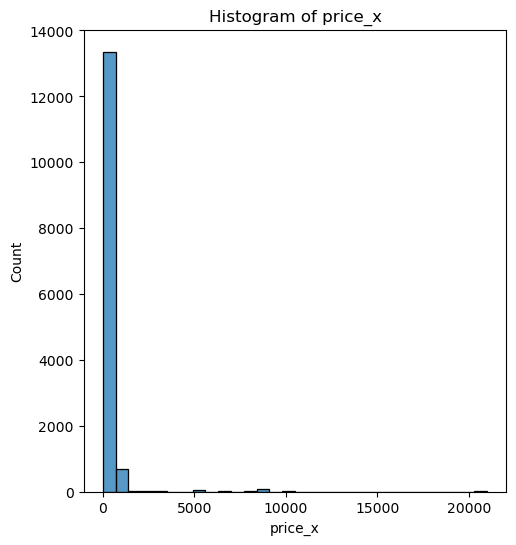

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


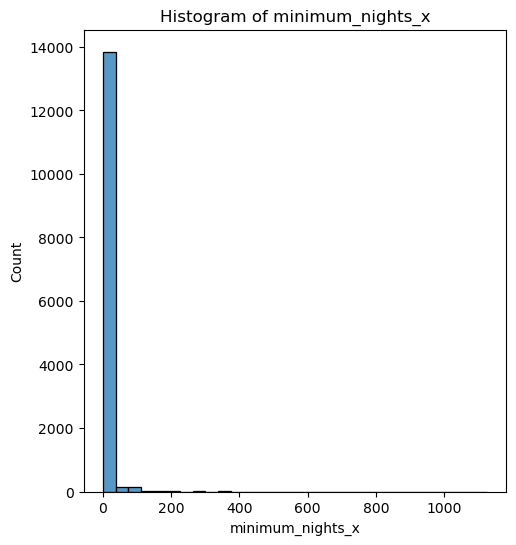

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


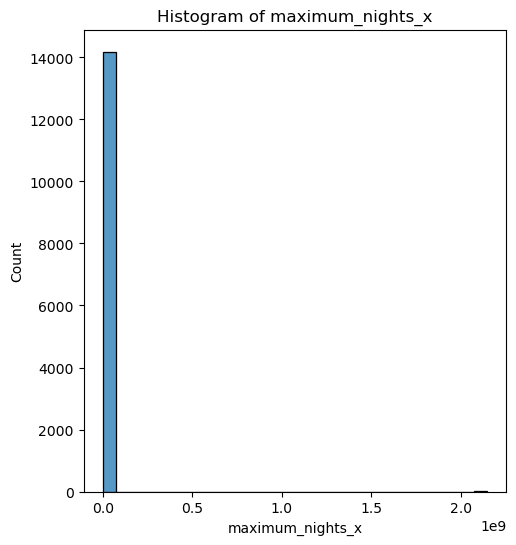

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


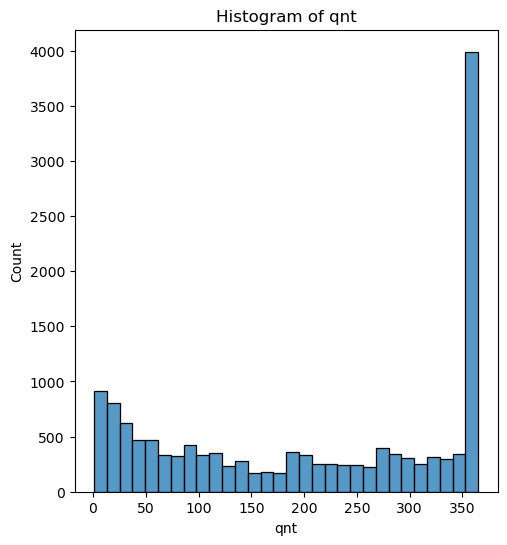

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


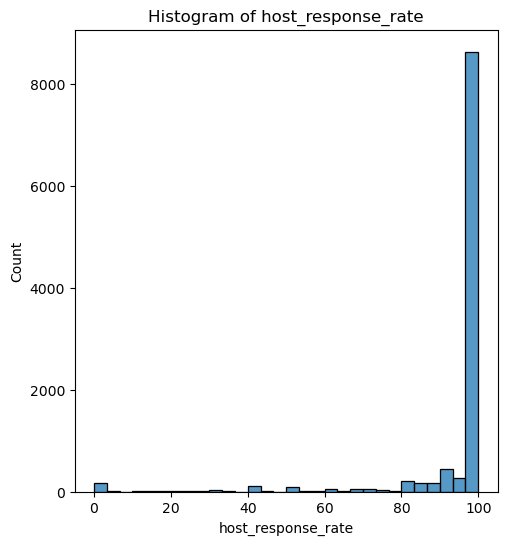

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


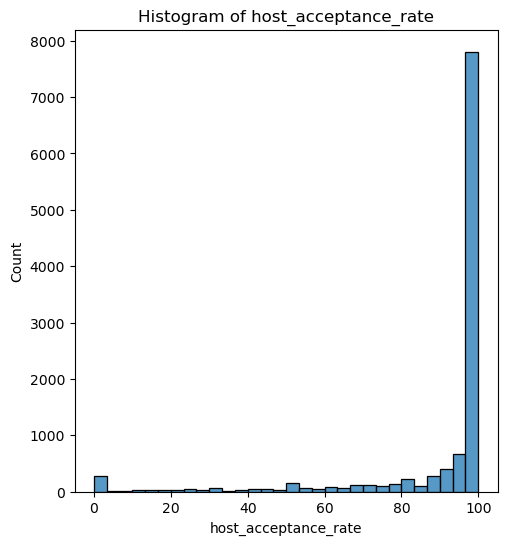

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


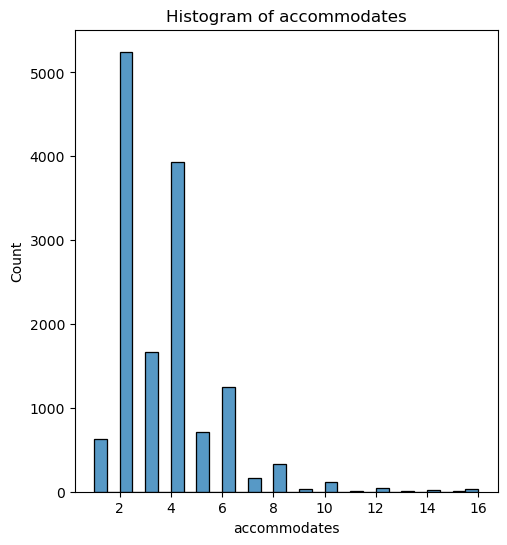

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


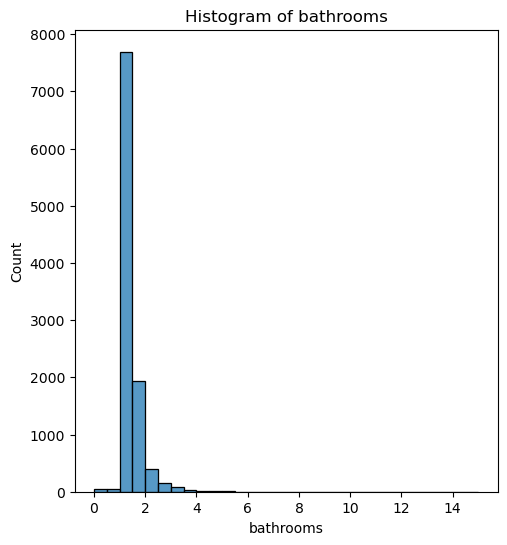

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


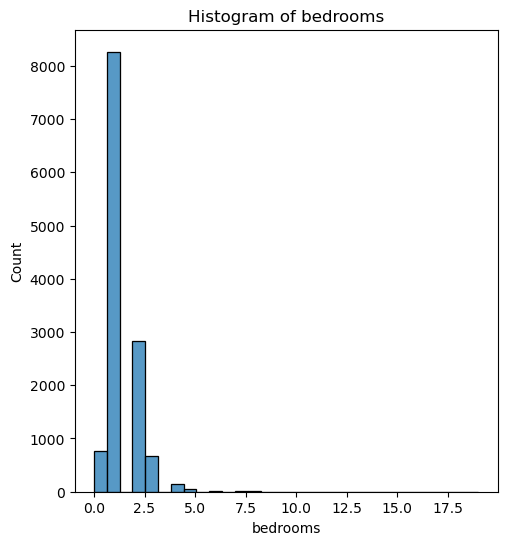

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


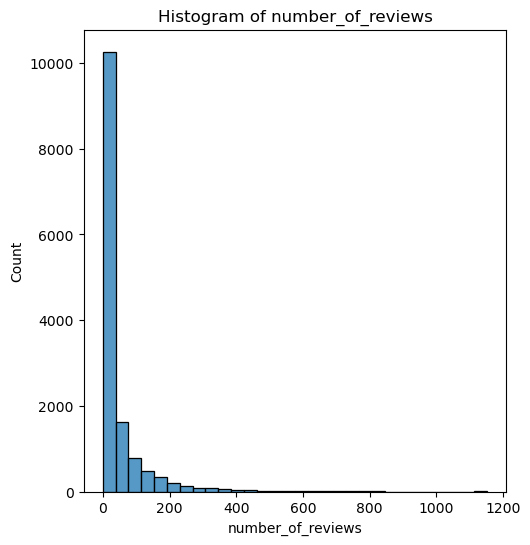

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


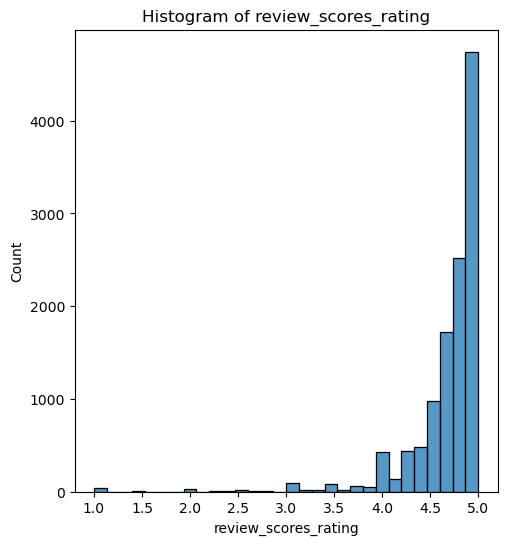

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


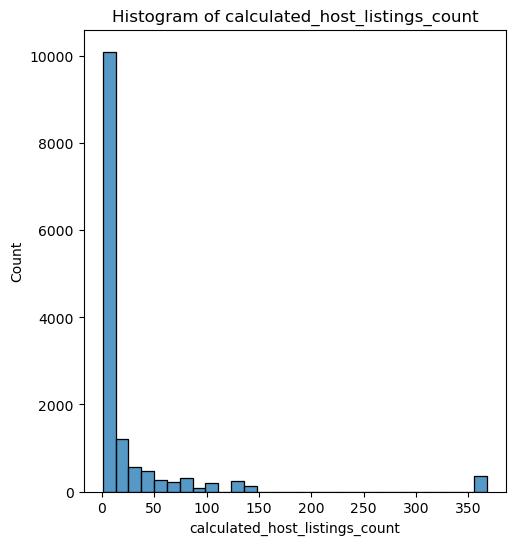

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


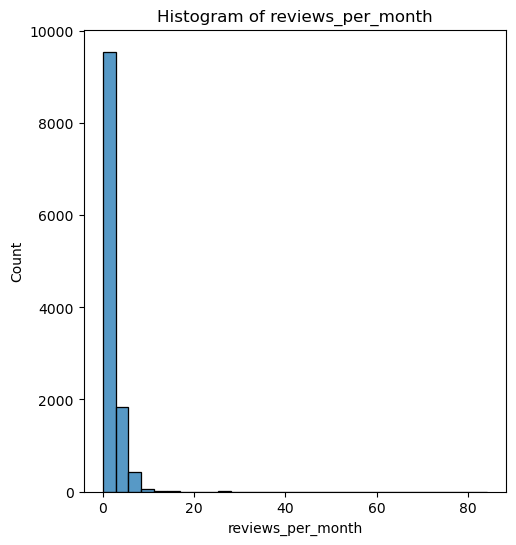

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


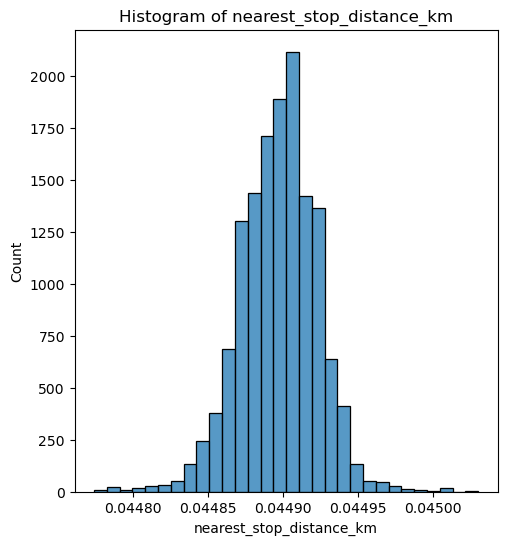

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


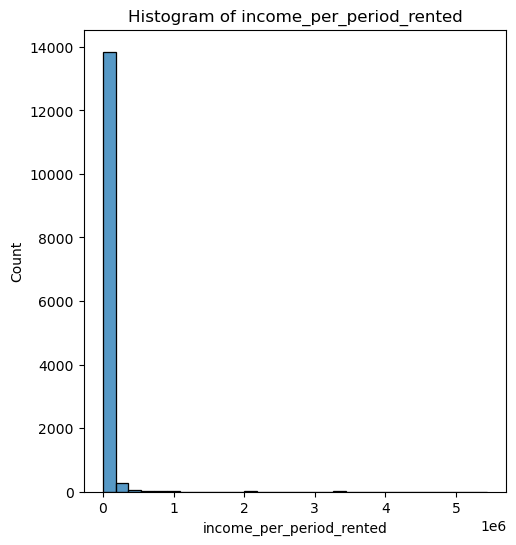

In [47]:
numeric_columns_excluding_id = [col for col in numeric_columns if col != 'listing_id']

for column in numeric_columns_excluding_id:
    plt.figure(figsize=(12, 6))

    # Histograms
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=30)
    plt.title(f'Histogram of {column}')

    plt.show()

In [48]:
# correlation matrix

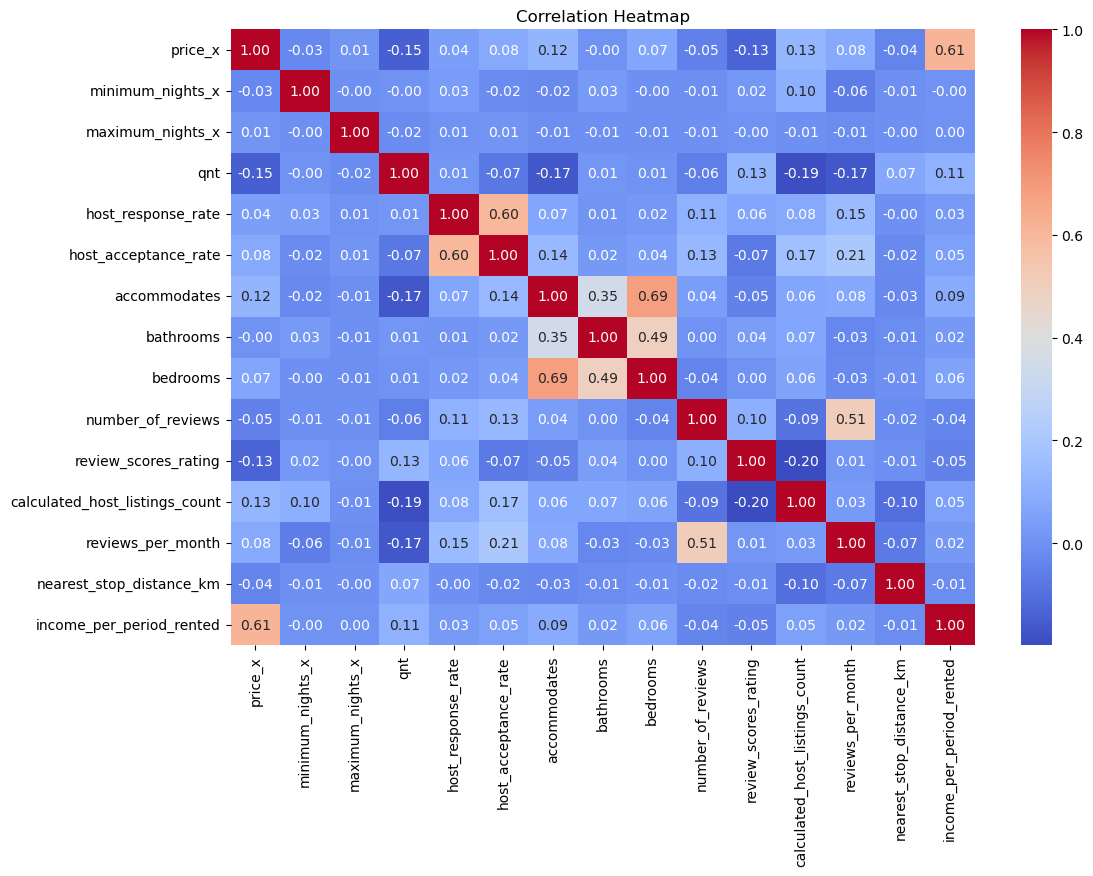

In [49]:
correlation_matrix = df[numeric_columns_excluding_id].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [50]:
# Analyze the relationship between pairs of features

# The relationship between price and the number of bedrooms
# The relationship between reviews and ratings
# The influence of the distance to the nearest stop on the price

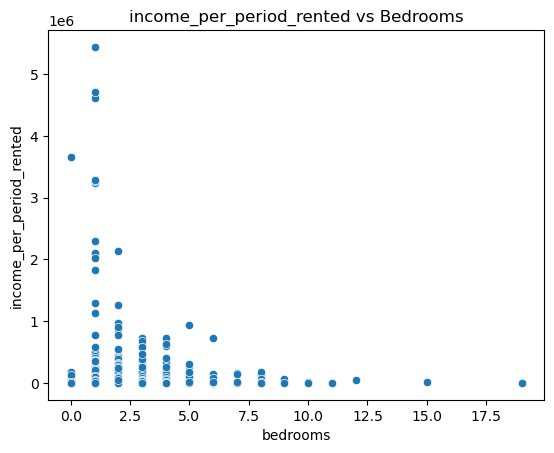

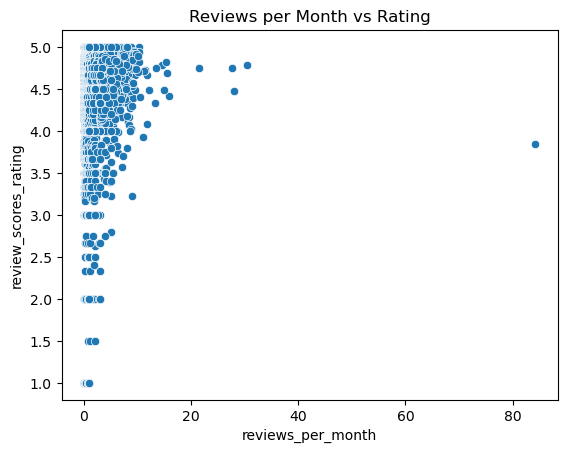

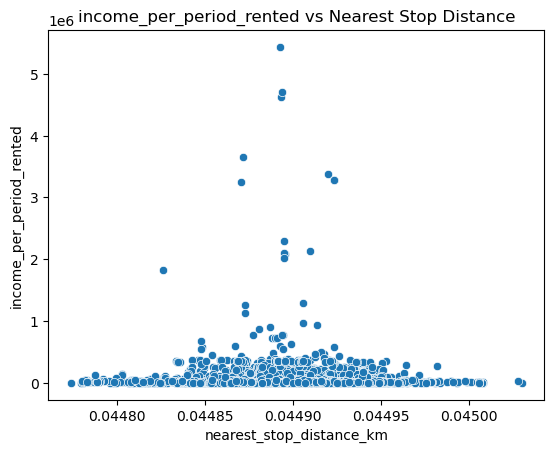

In [51]:
sns.scatterplot(data=df, x='bedrooms', y='income_per_period_rented')
plt.title('income_per_period_rented vs Bedrooms')
plt.show()

sns.scatterplot(data=df, x='reviews_per_month', y='review_scores_rating')
plt.title('Reviews per Month vs Rating')
plt.show()

sns.scatterplot(data=df, x='nearest_stop_distance_km', y='income_per_period_rented')
plt.title('income_per_period_rented vs Nearest Stop Distance')
plt.show()


In [52]:
# Relationship between reviews and superhosts

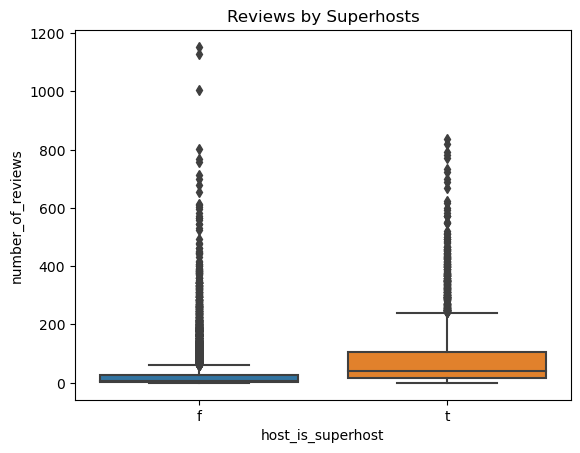

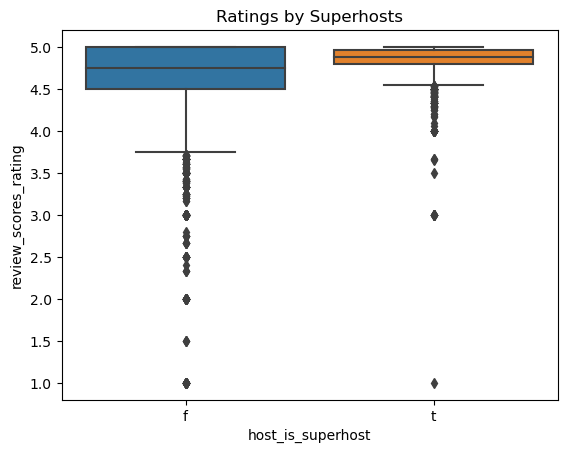

In [53]:
sns.boxplot(data=df, x='host_is_superhost', y='number_of_reviews')
plt.title('Reviews by Superhosts')
plt.show()

sns.boxplot(data=df, x='host_is_superhost', y='review_scores_rating')
plt.title('Ratings by Superhosts')
plt.show()


In [54]:
# categorical columns

In [55]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'amenities', 'nearest_pois'],
      dtype='object')


In [56]:
# all available values

for column in categorical_columns:
    print(f"Unique values in column {column}:")
    print(df[column].unique())
    print()


Unique values in column host_response_time:
['within an hour' nan 'within a few hours' 'within a day'
 'a few days or more']

Unique values in column host_is_superhost:
['f' 't' nan]

Unique values in column host_has_profile_pic:
['t' nan 'f']

Unique values in column host_identity_verified:
['t' 'f' nan]

Unique values in column neighbourhood_cleansed:
['Leopoldstadt', 'Rudolfsheim-Fnfhaus', 'Neubau', 'Ottakring', 'Hernals', ..., 'Donaustadt', 'Whring', 'Favoriten', 'Hietzing', 'Liesing']
Length: 23
Categories (23, object): ['Alsergrund', 'Brigittenau', 'Donaustadt', 'Dbling', ..., 'Rudolfsheim-Fnfhaus', 'Simmering', 'Wieden', 'Whring']

Unique values in column property_type:
['Entire rental unit', 'Private room in rental unit', 'Private room in condo', 'Entire condo', 'Entire serviced apartment', ..., 'Private room in barn', 'Barn', 'Castle', 'Shared room in bed and breakfast', 'Private room in dome']
Length: 54
Categories (54, object): ['Barn', 'Casa particular', 'Castle', 'Ent

/Users/mazen/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/mazen/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mazen/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mazen/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 138 (\x8a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


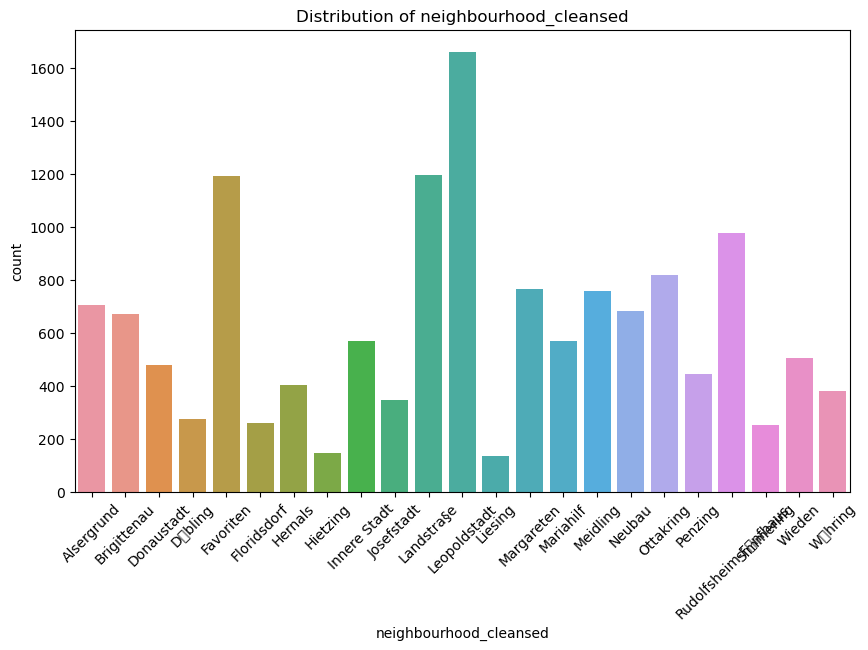

In [57]:
# distributin by districts

plt.figure(figsize=(10, 6))
sns.countplot(x='neighbourhood_cleansed', data=df)
plt.title(f'Distribution of {df["neighbourhood_cleansed"].name}')
plt.xticks(rotation=45)
plt.show()

## preprocessing

## split the datset into train, val, test

In [58]:
# Split into train and temp (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## preprocess categorical columns

In [59]:
categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'amenities', 'nearest_pois'],
      dtype='object')


In [60]:
# Check for missing values for categorical columns
missing_values_cat = train_df[categorical_columns].isnull().sum()
print(missing_values_cat)

host_response_time        2192
host_is_superhost          309
host_has_profile_pic         0
host_identity_verified       0
neighbourhood_cleansed       0
property_type                0
amenities                    0
nearest_pois                 0
dtype: int64


In [61]:
#  One-Hot Encoding
train_encoded = train_df['nearest_pois'].str.get_dummies(sep=', ')
val_encoded = val_df['nearest_pois'].str.get_dummies(sep=', ')
test_encoded = test_df['nearest_pois'].str.get_dummies(sep=', ')

# Append the encoded data back to the original DataFrame
train_df = pd.concat([train_df, train_encoded], axis=1)
val_df = pd.concat([val_df, val_encoded], axis=1)
test_df = pd.concat([test_df, test_encoded], axis=1)
train_df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,...,nearest_pois,income_per_period_rented,cafe_restaurant,education,entertainment_leisure,other,park,shops_and_retail,supermarket,transport_and_infrastructure
13777,1219382714494456612,999.0,1,179,7,within an hour,100.0,100.0,f,t,...,"shops_and_retail, education, park, transport_a...",6993.0,1,1,1,1,1,1,1,1
5466,42472678,27.0,1,6,365,NaN,NaN,NaN,f,t,...,"shops_and_retail, education, transport_and_inf...",9855.0,1,1,1,1,0,1,1,1
7646,675138931726139013,79.0,1,365,59,within an hour,100.0,99.0,f,t,...,"shops_and_retail, education, transport_and_inf...",4661.0,1,1,1,1,0,1,1,1
11164,1043380821072053551,30.0,1,365,365,within an hour,100.0,99.0,f,t,...,"shops_and_retail, education, transport_and_inf...",10950.0,1,1,1,1,0,1,1,1
11547,1079799572282979198,80.0,21,365,365,within an hour,100.0,100.0,NaN,t,...,"shops_and_retail, education, park, transport_a...",29200.0,1,1,1,1,1,1,1,1


In [62]:
# drop column 'nearest_pois' from DataFrame
train_df = train_df.drop(columns=['nearest_pois'])
val_df = val_df.drop(columns=['nearest_pois'])
test_df = test_df.drop(columns=['nearest_pois'])
train_df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,...,nearest_stop_distance_km,income_per_period_rented,cafe_restaurant,education,entertainment_leisure,other,park,shops_and_retail,supermarket,transport_and_infrastructure
13777,1219382714494456612,999.0,1,179,7,within an hour,100.0,100.0,f,t,...,0.044903,6993.0,1,1,1,1,1,1,1,1
5466,42472678,27.0,1,6,365,NaN,NaN,NaN,f,t,...,0.044883,9855.0,1,1,1,1,0,1,1,1
7646,675138931726139013,79.0,1,365,59,within an hour,100.0,99.0,f,t,...,0.044895,4661.0,1,1,1,1,0,1,1,1
11164,1043380821072053551,30.0,1,365,365,within an hour,100.0,99.0,f,t,...,0.044921,10950.0,1,1,1,1,0,1,1,1
11547,1079799572282979198,80.0,21,365,365,within an hour,100.0,100.0,NaN,t,...,0.044921,29200.0,1,1,1,1,1,1,1,1


In [63]:
# Applying One-Hot Encoding with .loc
train_df = pd.get_dummies(train_df, columns=['host_response_time'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['host_response_time'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['host_response_time'], drop_first=True)
train_df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,...,education,entertainment_leisure,other,park,shops_and_retail,supermarket,transport_and_infrastructure,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
13777,1219382714494456612,999.0,1,179,7,100.0,100.0,f,t,t,...,1,1,1,1,1,1,1,False,False,True
5466,42472678,27.0,1,6,365,NaN,NaN,f,t,t,...,1,1,1,0,1,1,1,False,False,False
7646,675138931726139013,79.0,1,365,59,100.0,99.0,f,t,t,...,1,1,1,0,1,1,1,False,False,True
11164,1043380821072053551,30.0,1,365,365,100.0,99.0,f,t,t,...,1,1,1,0,1,1,1,False,False,True
11547,1079799572282979198,80.0,21,365,365,100.0,100.0,NaN,t,t,...,1,1,1,1,1,1,1,False,False,True


In [64]:
# Replace NaN with 'f' using .loc
train_df.loc[:, 'host_is_superhost'] = train_df['host_is_superhost'].fillna('f')
val_df.loc[:, 'host_is_superhost'] = val_df['host_is_superhost'].fillna('f')
test_df.loc[:, 'host_is_superhost'] = test_df['host_is_superhost'].fillna('f')

# Apply One-Hot Encoding using get_dummies
train_df = pd.get_dummies(train_df, columns=['host_is_superhost'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['host_is_superhost'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['host_is_superhost'], drop_first=True)
train_df.head()


,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,entertainment_leisure,other,park,shops_and_retail,supermarket,transport_and_infrastructure,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t
13777,1219382714494456612,999.0,1,179,7,100.0,100.0,t,t,Mariahilf,...,1,1,1,1,1,1,False,False,True,False
5466,42472678,27.0,1,6,365,NaN,NaN,t,t,Margareten,...,1,1,0,1,1,1,False,False,False,False
7646,675138931726139013,79.0,1,365,59,100.0,99.0,t,t,Leopoldstadt,...,1,1,0,1,1,1,False,False,True,False
11164,1043380821072053551,30.0,1,365,365,100.0,99.0,t,t,Whring,...,1,1,0,1,1,1,False,False,True,False
11547,1079799572282979198,80.0,21,365,365,100.0,100.0,t,t,Ottakring,...,1,1,1,1,1,1,False,False,True,False


In [65]:
# Apply One-Hot Encoding using get_dummies for both columns
train_df = pd.get_dummies(train_df, columns=['host_has_profile_pic'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['host_has_profile_pic'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['host_has_profile_pic'], drop_first=True)

train_df = pd.get_dummies(train_df, columns=['host_identity_verified'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['host_identity_verified'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['host_identity_verified'], drop_first=True)
train_df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_rate,host_acceptance_rate,neighbourhood_cleansed,property_type,accommodates,...,park,shops_and_retail,supermarket,transport_and_infrastructure,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t
13777,1219382714494456612,999.0,1,179,7,100.0,100.0,Mariahilf,Entire rental unit,16,...,1,1,1,1,False,False,True,False,True,True
5466,42472678,27.0,1,6,365,NaN,NaN,Margareten,Private room in rental unit,2,...,0,1,1,1,False,False,False,False,True,True
7646,675138931726139013,79.0,1,365,59,100.0,99.0,Leopoldstadt,Entire rental unit,2,...,0,1,1,1,False,False,True,False,True,True
11164,1043380821072053551,30.0,1,365,365,100.0,99.0,Whring,Private room in home,1,...,0,1,1,1,False,False,True,False,True,True
11547,1079799572282979198,80.0,21,365,365,100.0,100.0,Ottakring,Entire rental unit,5,...,1,1,1,1,False,False,True,False,True,True


In [66]:
train_df['neighbourhood_cleansed'] = train_df['neighbourhood_cleansed'].str.replace('Dbling', 'Dobling')
val_df['neighbourhood_cleansed'] = val_df['neighbourhood_cleansed'].str.replace('Dbling', 'Dobling')
test_df['neighbourhood_cleansed'] = test_df['neighbourhood_cleansed'].str.replace('Dbling', 'Dobling')

train_df['neighbourhood_cleansed'] = train_df['neighbourhood_cleansed'].str.replace('Whring', 'Wahring')
val_df['neighbourhood_cleansed'] = val_df['neighbourhood_cleansed'].str.replace('Whring', 'Wahring')
test_df['neighbourhood_cleansed'] = test_df['neighbourhood_cleansed'].str.replace('Whring', 'Wahring')

train_df['neighbourhood_cleansed'] = train_df['neighbourhood_cleansed'].str.replace('Rudolfsheim-Fnfhaus', 'Rudolfsheim-Funfhaus')
val_df['neighbourhood_cleansed'] = val_df['neighbourhood_cleansed'].str.replace('Rudolfsheim-Fnfhaus', 'Rudolfsheim-Funfhaus')
test_df['neighbourhood_cleansed'] = test_df['neighbourhood_cleansed'].str.replace('Rudolfsheim-Fnfhaus', 'Rudolfsheim-Funfhaus')
train_df.head()


,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_rate,host_acceptance_rate,neighbourhood_cleansed,property_type,accommodates,...,park,shops_and_retail,supermarket,transport_and_infrastructure,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t
13777,1219382714494456612,999.0,1,179,7,100.0,100.0,Mariahilf,Entire rental unit,16,...,1,1,1,1,False,False,True,False,True,True
5466,42472678,27.0,1,6,365,NaN,NaN,Margareten,Private room in rental unit,2,...,0,1,1,1,False,False,False,False,True,True
7646,675138931726139013,79.0,1,365,59,100.0,99.0,Leopoldstadt,Entire rental unit,2,...,0,1,1,1,False,False,True,False,True,True
11164,1043380821072053551,30.0,1,365,365,100.0,99.0,Wahring,Private room in home,1,...,0,1,1,1,False,False,True,False,True,True
11547,1079799572282979198,80.0,21,365,365,100.0,100.0,Ottakring,Entire rental unit,5,...,1,1,1,1,False,False,True,False,True,True


In [67]:
train_df = pd.get_dummies(train_df, columns=['neighbourhood_cleansed'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['neighbourhood_cleansed'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['neighbourhood_cleansed'], drop_first=True)
train_df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_rate,host_acceptance_rate,property_type,accommodates,bathrooms,...,neighbourhood_cleansed_Margareten,neighbourhood_cleansed_Mariahilf,neighbourhood_cleansed_Meidling,neighbourhood_cleansed_Neubau,neighbourhood_cleansed_Ottakring,neighbourhood_cleansed_Penzing,neighbourhood_cleansed_Rudolfsheim-Funfhaus,neighbourhood_cleansed_Simmering,neighbourhood_cleansed_Wahring,neighbourhood_cleansed_Wieden
13777,1219382714494456612,999.0,1,179,7,100.0,100.0,Entire rental unit,16,15.0,...,False,True,False,False,False,False,False,False,False,False
5466,42472678,27.0,1,6,365,NaN,NaN,Private room in rental unit,2,NaN,...,True,False,False,False,False,False,False,False,False,False
7646,675138931726139013,79.0,1,365,59,100.0,99.0,Entire rental unit,2,1.0,...,False,False,False,False,False,False,False,False,False,False
11164,1043380821072053551,30.0,1,365,365,100.0,99.0,Private room in home,1,NaN,...,False,False,False,False,False,False,False,False,True,False
11547,1079799572282979198,80.0,21,365,365,100.0,100.0,Entire rental unit,5,1.0,...,False,False,False,False,True,False,False,False,False,False


In [68]:
# Function to merge categories in property types
def reduce_property_type(property_type):
    if 'Entire' in property_type:
        return 'Entire'
    elif 'Private room' in property_type:
        return 'Private room'
    elif 'Shared room' in property_type:
        return 'Shared room'
    elif 'Room in' in property_type:
        return 'Room in hotel or similar'
    else:
        return 'Other'

# Apply the function with .loc
train_df.loc[:, 'property_type'] = train_df['property_type'].apply(reduce_property_type)
val_df.loc[:, 'property_type'] = val_df['property_type'].apply(reduce_property_type)
test_df.loc[:, 'property_type'] = test_df['property_type'].apply(reduce_property_type)

# Apply One-Hot Encoding with .loc
train_df = pd.get_dummies(train_df, columns=['property_type'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['property_type'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['property_type'], drop_first=True)

train_df.head()

/var/folders/pb/h24lzqkx5tl7grb__x443ggc0000gn/T/ipykernel_71138/1016229789.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Entire' 'Private room' 'Entire' ... 'Private room' 'Entire' 'Entire']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  train_df.loc[:, 'property_type'] = train_df['property_type'].apply(reduce_property_type)
/var/folders/pb/h24lzqkx5tl7grb__x443ggc0000gn/T/ipykernel_71138/1016229789.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Entire' 'Entire' 'Entire' ... 'Private room' 'Shared room' 'Entire']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  val_df.loc[:, 'property_type'] = val_df['property_type'].apply(reduce_property_type)
/var/folders/pb/h24lzqkx5tl7grb__x443ggc0000gn/T/ipykernel_71138/1016229789.py:17: FutureWarnin

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,...,neighbourhood_cleansed_Ottakring,neighbourhood_cleansed_Penzing,neighbourhood_cleansed_Rudolfsheim-Funfhaus,neighbourhood_cleansed_Simmering,neighbourhood_cleansed_Wahring,neighbourhood_cleansed_Wieden,property_type_Other,property_type_Private room,property_type_Room in hotel or similar,property_type_Shared room
13777,1219382714494456612,999.0,1,179,7,100.0,100.0,16,15.0,15.0,...,False,False,False,False,False,False,False,False,False,False
5466,42472678,27.0,1,6,365,NaN,NaN,2,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
7646,675138931726139013,79.0,1,365,59,100.0,99.0,2,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
11164,1043380821072053551,30.0,1,365,365,100.0,99.0,1,NaN,NaN,...,False,False,False,False,True,False,False,True,False,False
11547,1079799572282979198,80.0,21,365,365,100.0,100.0,5,1.0,2.0,...,True,False,False,False,False,False,False,False,False,False


In [69]:
#  One-Hot Encoding
train_encoded = train_df['amenities'].str.get_dummies(sep=', ')
val_encoded = val_df['amenities'].str.get_dummies(sep=', ')
test_encoded = test_df['amenities'].str.get_dummies(sep=', ')

# Append the encoded data back to the original DataFrame
train_df = pd.concat([train_df, train_encoded], axis=1)
val_df = pd.concat([val_df, val_encoded], axis=1)
test_df = pd.concat([test_df, test_encoded], axis=1)

train_df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,qnt,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,...,neighbourhood_cleansed_Wahring,neighbourhood_cleansed_Wieden,property_type_Other,property_type_Private room,property_type_Room in hotel or similar,property_type_Shared room,Essentials,Hair dryer,Kitchen,Wifi
13777,1219382714494456612,999.0,1,179,7,100.0,100.0,16,15.0,15.0,...,False,False,False,False,False,False,1,1,0,1
5466,42472678,27.0,1,6,365,NaN,NaN,2,NaN,NaN,...,False,False,False,True,False,False,1,1,1,1
7646,675138931726139013,79.0,1,365,59,100.0,99.0,2,1.0,1.0,...,False,False,False,False,False,False,1,1,1,1
11164,1043380821072053551,30.0,1,365,365,100.0,99.0,1,NaN,NaN,...,True,False,False,True,False,False,1,1,1,1
11547,1079799572282979198,80.0,21,365,365,100.0,100.0,5,1.0,2.0,...,False,False,False,False,False,False,1,1,1,1


In [70]:
# drop column 'amenities' from DataFrame
train_df = train_df.drop(columns=['amenities'])
val_df = val_df.drop(columns=['amenities'])
test_df = test_df.drop(columns=['amenities'])

# drop column 'listing_id' from DataFrame
train_df = train_df.drop(columns=['listing_id'])
val_df = val_df.drop(columns=['listing_id'])
test_df = test_df.drop(columns=['listing_id'])

In [71]:
train_df.columns

Index(['price_x', 'minimum_nights_x', 'maximum_nights_x', 'qnt',
       'host_response_rate', 'host_acceptance_rate', 'accommodates',
       'bathrooms', 'bedrooms', 'number_of_reviews', 'review_scores_rating',
       'calculated_host_listings_count', 'reviews_per_month',
       'nearest_stop_distance_km', 'income_per_period_rented',
       'cafe_restaurant', 'education', 'entertainment_leisure', 'other',
       'park', 'shops_and_retail', 'supermarket',
       'transport_and_infrastructure', 'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_is_superhost_t',
       'host_has_profile_pic_t', 'host_identity_verified_t',
       'neighbourhood_cleansed_Brigittenau', 'neighbourhood_cleansed_Dobling',
       'neighbourhood_cleansed_Donaustadt', 'neighbourhood_cleansed_Favoriten',
       'neighbourhood_cleansed_Floridsdorf', 'neighbourhood_cleansed_Hernals',
       'neighbourhood_cleansed_Hietzing',
       'nei

In [72]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8514 entries, 13777 to 7270
Data columns (total 59 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   price_x                                      8514 non-null   float64
 1   minimum_nights_x                             8514 non-null   int64  
 2   maximum_nights_x                             8514 non-null   int64  
 3   qnt                                          8514 non-null   int64  
 4   host_response_rate                           6322 non-null   float64
 5   host_acceptance_rate                         6633 non-null   float64
 6   accommodates                                 8514 non-null   int64  
 7   bathrooms                                    6256 non-null   float64
 8   bedrooms                                     7651 non-null   float64
 9   number_of_reviews                            8514 non-null   int64  
 10  r

In [73]:
# Renaming columns
train_df.columns = train_df.columns.str.replace('host_is_superhost_t', 'is_superhost')
train_df.columns = train_df.columns.str.replace('host_has_profile_pic_t', 'host_has_profile_pic')
train_df.columns = train_df.columns.str.replace('host_identity_verified_t', 'host_identity_verified')
train_df.columns = train_df.columns.str.replace('neighbourhood_cleansed_', 'neighbourhood_')
train_df.columns = train_df.columns.str.replace('property_type_', 'property_type_')

val_df.columns = val_df.columns.str.replace('host_is_superhost_t', 'is_superhost')
val_df.columns = val_df.columns.str.replace('host_has_profile_pic_t', 'host_has_profile_pic')
val_df.columns = val_df.columns.str.replace('host_identity_verified_t', 'host_identity_verified')
val_df.columns = val_df.columns.str.replace('neighbourhood_cleansed_', 'neighbourhood_')
val_df.columns = val_df.columns.str.replace('property_type_', 'property_type_')

test_df.columns = test_df.columns.str.replace('host_is_superhost_t', 'is_superhost')
test_df.columns = test_df.columns.str.replace('host_has_profile_pic_t', 'host_has_profile_pic')
test_df.columns = test_df.columns.str.replace('host_identity_verified_t', 'host_identity_verified')
test_df.columns = test_df.columns.str.replace('neighbourhood_cleansed_', 'neighbourhood_')
test_df.columns = test_df.columns.str.replace('property_type_', 'property_type_')

train_df.columns = train_df.columns.str.replace('price_x', 'price')
train_df.columns = train_df.columns.str.replace('minimum_nights_x', 'min_nights')
train_df.columns = train_df.columns.str.replace('maximum_nights_x', 'max_nights')
train_df.columns = train_df.columns.str.replace('host_response_rate', 'host_response_rate')
train_df.columns = train_df.columns.str.replace('host_acceptance_rate', 'host_acceptance_rate')
train_df.columns = train_df.columns.str.replace('calculated_host_listings_count', 'host_has_listings')

val_df.columns = val_df.columns.str.replace('price_x', 'price')
val_df.columns = val_df.columns.str.replace('minimum_nights_x', 'min_nights')
val_df.columns = val_df.columns.str.replace('maximum_nights_x', 'max_nights')
val_df.columns = val_df.columns.str.replace('host_response_rate', 'host_response_rate')
val_df.columns = val_df.columns.str.replace('host_acceptance_rate', 'host_acceptance_rate')
val_df.columns = val_df.columns.str.replace('calculated_host_listings_count', 'host_has_listings')

test_df.columns = test_df.columns.str.replace('price_x', 'price')
test_df.columns = test_df.columns.str.replace('minimum_nights_x', 'min_nights')
test_df.columns = test_df.columns.str.replace('maximum_nights_x', 'max_nights')
test_df.columns = test_df.columns.str.replace('host_response_rate', 'host_response_rate')
test_df.columns = test_df.columns.str.replace('host_acceptance_rate', 'host_acceptance_rate')
test_df.columns = test_df.columns.str.replace('calculated_host_listings_count', 'host_has_listings')


train_df.columns = train_df.columns.str.replace(' ', '_')
val_df.columns = val_df.columns.str.replace(' ', '_')
test_df.columns = test_df.columns.str.replace(' ', '_')

print(train_df.columns)

Index(['price', 'min_nights', 'max_nights', 'qnt', 'host_response_rate',
       'host_acceptance_rate', 'accommodates', 'bathrooms', 'bedrooms',
       'number_of_reviews', 'review_scores_rating', 'host_has_listings',
       'reviews_per_month', 'nearest_stop_distance_km',
       'income_per_period_rented', 'cafe_restaurant', 'education',
       'entertainment_leisure', 'other', 'park', 'shops_and_retail',
       'supermarket', 'transport_and_infrastructure',
       'host_response_time_within_a_day',
       'host_response_time_within_a_few_hours',
       'host_response_time_within_an_hour', 'is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_Brigittenau', 'neighbourhood_Dobling',
       'neighbourhood_Donaustadt', 'neighbourhood_Favoriten',
       'neighbourhood_Floridsdorf', 'neighbourhood_Hernals',
       'neighbourhood_Hietzing', 'neighbourhood_Innere_Stadt',
       'neighbourhood_Josefstadt', 'neighbourhood_Landstra§e',
       'neighbourho

In [74]:
train_df

,price,min_nights,max_nights,qnt,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,number_of_reviews,...,neighbourhood_Wahring,neighbourhood_Wieden,property_type_Other,property_type_Private_room,property_type_Room_in_hotel_or_similar,property_type_Shared_room,Essentials,Hair_dryer,Kitchen,Wifi
13777,999.0,1,179,7,100.0,100.0,16,15.0,15.0,0,...,False,False,False,False,False,False,1,1,0,1
5466,27.0,1,6,365,NaN,NaN,2,NaN,NaN,26,...,False,False,False,True,False,False,1,1,1,1
7646,79.0,1,365,59,100.0,99.0,2,1.0,1.0,143,...,False,False,False,False,False,False,1,1,1,1
11164,30.0,1,365,365,100.0,99.0,1,NaN,NaN,20,...,True,False,False,True,False,False,1,1,1,1
11547,80.0,21,365,365,100.0,100.0,5,1.0,2.0,0,...,False,False,False,False,False,False,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,80.0,3,1125,365,NaN,NaN,4,NaN,NaN,5,...,False,False,False,False,False,False,1,1,1,1
13418,1000.0,1,365,355,100.0,98.0,6,1.0,1.0,2,...,False,False,False,False,False,False,1,1,1,1
5390,30.0,1,1125,365,NaN,NaN,2,NaN,NaN,0,...,False,False,False,True,False,False,1,1,1,1
860,130.0,2,35,340,100.0,100.0,6,1.0,3.0,104,...,False,False,False,False,False,False,1,0,1,1


## preprocess numeric columns

In [75]:
# check for outliers

In [76]:
# we are interested only in rated properties
train_df = train_df[~train_df['reviews_per_month'].isna()]
numeric_columns = train_df.select_dtypes(include=['number']).columns

# Calculate Q1, Q3 and IQR
Q1 = train_df[numeric_columns].quantile(0.25)
Q3 = train_df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Define ranges without outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# We leave only those lines that do not contain outliers
train_df = train_df[~((train_df[numeric_columns] < lower_bound) | (train_df[numeric_columns] > upper_bound)).any(axis=1)]
#val_df = val_df[~((val_df[numeric_columns] < lower_bound) | (val_df[numeric_columns] > upper_bound)).any(axis=1)]
#test_df = test_df[~((test_df[numeric_columns] < lower_bound) | (test_df[numeric_columns] > upper_bound)).any(axis=1)]


In [77]:
# scaling features
from sklearn.preprocessing import StandardScaler

X_train = train_df.drop(columns=['income_per_period_rented'])
y_train = train_df['income_per_period_rented']

X_val = val_df.drop(columns=['income_per_period_rented'])
y_val = val_df['income_per_period_rented']

X_test = test_df.drop(columns=['income_per_period_rented'])
y_test = test_df['income_per_period_rented']

# Fit on train data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test and validation data
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [78]:
numeric_columns = X_train.select_dtypes(include=['number']).columns
print(numeric_columns)

Index(['price', 'min_nights', 'max_nights', 'qnt', 'host_response_rate',
       'host_acceptance_rate', 'accommodates', 'bathrooms', 'bedrooms',
       'number_of_reviews', 'review_scores_rating', 'host_has_listings',
       'reviews_per_month', 'nearest_stop_distance_km', 'cafe_restaurant',
       'education', 'entertainment_leisure', 'other', 'park',
       'shops_and_retail', 'supermarket', 'transport_and_infrastructure',
       'Essentials', 'Hair_dryer', 'Kitchen', 'Wifi'],
      dtype='object')


In [79]:
# Check for missing values for numeric columns
missing_values = X_train[numeric_columns].isnull().sum()
print(missing_values)

price                             0
min_nights                        0
max_nights                        0
qnt                               0
host_response_rate              737
host_acceptance_rate            674
accommodates                      0
bathrooms                       730
bedrooms                        298
number_of_reviews                 0
review_scores_rating              0
host_has_listings                 0
reviews_per_month                 0
nearest_stop_distance_km          0
cafe_restaurant                   0
education                         0
entertainment_leisure             0
other                             0
park                              0
shops_and_retail                  0
supermarket                       0
transport_and_infrastructure      0
Essentials                        0
Hair_dryer                        0
Kitchen                           0
Wifi                              0
dtype: int64


In [80]:
# round rating columns to 1 decimal place
X_train['review_scores_rating'] = X_train['review_scores_rating'].round(1)
X_train['number_of_reviews'] = X_train['number_of_reviews'].round(1)

In [81]:
# Check for missing values for numeric columns
missing_values = X_train[numeric_columns].isnull().sum()
print(missing_values)

price                             0
min_nights                        0
max_nights                        0
qnt                               0
host_response_rate              737
host_acceptance_rate            674
accommodates                      0
bathrooms                       730
bedrooms                        298
number_of_reviews                 0
review_scores_rating              0
host_has_listings                 0
reviews_per_month                 0
nearest_stop_distance_km          0
cafe_restaurant                   0
education                         0
entertainment_leisure             0
other                             0
park                              0
shops_and_retail                  0
supermarket                       0
transport_and_infrastructure      0
Essentials                        0
Hair_dryer                        0
Kitchen                           0
Wifi                              0
dtype: int64


In [82]:
# filling host_response_rate, host_acceptance_rate, bathrooms, bedrooms with k-nearest
# This method works by finding the k-nearest neighbors of a data point (based on other features) and imputing missing values with the average (or weighted average) of the corresponding values from those neighbors.
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights="distance")

X_train_scaled = imputer.fit_transform(X_train)
X_val_scaled = imputer.transform(X_val)
X_test_scaled = imputer.transform(X_test)

# Convert back to DataFrame for inspection
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled

,price,min_nights,max_nights,qnt,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,number_of_reviews,...,neighbourhood_Wahring,neighbourhood_Wieden,property_type_Other,property_type_Private_room,property_type_Room_in_hotel_or_similar,property_type_Shared_room,Essentials,Hair_dryer,Kitchen,Wifi
0,27.0,1.0,6.0,365.0,100.0,93.187403,2.0,1.101196,1.254510,26.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1,30.0,1.0,365.0,365.0,100.0,99.000000,1.0,1.000000,1.000000,20.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,70.0,4.0,1125.0,365.0,100.0,100.000000,4.0,1.076914,1.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,100.0,1.0,90.0,357.0,100.0,100.000000,2.0,1.000000,1.000000,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,69.0,2.0,1125.0,361.0,100.0,100.000000,4.0,1.000000,1.000000,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,75.0,4.0,1125.0,365.0,100.0,100.000000,4.0,1.089473,2.000000,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1710,50.0,5.0,50.0,365.0,100.0,98.569455,2.0,1.192243,1.215743,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1711,30.0,1.0,1125.0,365.0,100.0,100.000000,2.0,1.000000,1.418472,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1712,45.0,2.0,16.0,365.0,100.0,96.791505,3.0,1.174462,1.184498,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [83]:
# Selecting best k features
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Apply SelectKBest with f_regression
selector = SelectKBest(score_func=mutual_info_regression, k=10)  # Select top 10 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

X_train_selected = pd.DataFrame(X_train_selected,
                                columns=X_train_scaled.columns[selector.get_support()])

X_train_selected

,price,qnt,host_acceptance_rate,bathrooms,bedrooms,host_has_listings,reviews_per_month,host_response_time_within_an_hour,is_superhost,property_type_Private_room
0,27.0,365.0,93.187403,1.101196,1.254510,1.0,0.47,0.0,0.0,1.0
1,30.0,365.0,99.000000,1.000000,1.000000,7.0,2.23,1.0,0.0,1.0
2,70.0,365.0,100.000000,1.076914,1.000000,1.0,0.02,0.0,0.0,0.0
3,100.0,357.0,100.000000,1.000000,1.000000,1.0,0.59,0.0,0.0,0.0
4,69.0,361.0,100.000000,1.000000,1.000000,1.0,0.82,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1709,75.0,365.0,100.000000,1.089473,2.000000,1.0,0.05,0.0,0.0,0.0
1710,50.0,365.0,98.569455,1.192243,1.215743,1.0,0.14,0.0,0.0,0.0
1711,30.0,365.0,100.000000,1.000000,1.418472,1.0,0.07,0.0,0.0,1.0
1712,45.0,365.0,96.791505,1.174462,1.184498,1.0,0.14,0.0,0.0,0.0


In [84]:
X_train_selected = pd.DataFrame(X_train_selected,
                                columns=X_train_scaled.columns[selector.get_support()])

In [85]:
train_df.to_csv('train_data_processed.csv', index=False)
val_df.to_csv('val_data_processed.csv', index=False)
test_df.to_csv('test_data_processed.csv', index=False)

X_train_selected.to_csv('X_train_selected.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

X_val_scaled.to_csv('X_val_scaled.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

X_test_scaled.to_csv('X_test_scaled.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [2]:
X_train = pd.read_csv('X_train_selected.csv')
y_train = pd.read_csv('y_train.csv').squeeze()  
X_val = pd.read_csv('X_val_scaled.csv')
y_val = pd.read_csv('y_val.csv').squeeze()
X_test = pd.read_csv('X_test_scaled.csv')
y_test = pd.read_csv('y_test.csv').squeeze()
common_features = X_train.columns.intersection(X_val.columns).intersection(X_test.columns)

X_train = X_train[common_features]
X_val = X_val[common_features]
X_test = X_test[common_features]

X_train = X_train.drop("price",axis = 1)
X_val = X_val.drop("price",axis = 1)
X_test = X_test.drop("price",axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714 entries, 0 to 1713
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price                              1714 non-null   float64
 1   qnt                                1714 non-null   float64
 2   host_acceptance_rate               1714 non-null   float64
 3   bathrooms                          1714 non-null   float64
 4   bedrooms                           1714 non-null   float64
 5   host_has_listings                  1714 non-null   float64
 6   reviews_per_month                  1714 non-null   float64
 7   host_response_time_within_an_hour  1714 non-null   float64
 8   is_superhost                       1714 non-null   float64
 9   property_type_Private_room         1714 non-null   float64
dtypes: float64(10)
memory usage: 134.0 KB
None


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Random Forest Regressor - Best Parameters: {grid_search.best_params_}')
print(f'Validation MSE: {val_mse:.4f}, Validation R²: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}')

Random Forest Regressor - Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Validation MSE: 7111509941.2735, Validation R²: 0.0145
Test MSE: 23016143924.5675, Test R²: 0.0039


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_test_pred = lr_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Linear Regression - Test MSE: {test_mse:.4f}')
print(f'Linear Regression - Test R²: {test_r2:.4f}')


Linear Regression - Test MSE: 22977204366.8394
Linear Regression - Test R²: 0.0056


In [26]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

ridge_model = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Ridge Regression - Best Parameters: {grid_search.best_params_}')
print(f'Validation MSE: {val_mse:.4f}, Validation R²: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}')

Ridge Regression - Best Parameters: {'alpha': 1.0}
Validation MSE: 7066917339.8025, Validation R²: 0.0207
Test MSE: 22977117207.1671, Test R²: 0.0056
Linear Regression - Cross-Validated MSE: 62331504.0348
Linear Regression - Cross-Validated R²: 0.5359


In [22]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Lasso Regression - Best Parameters: {grid_search.best_params_}')
print(f'Validation MSE: {val_mse:.4f}, Validation R²: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}')

Lasso Regression - Best Parameters: {'alpha': 0.01}
Validation MSE: 7066969060.8570, Validation R²: 0.0207
Test MSE: 22977204736.5804, Test R²: 0.0056


In [23]:
from sklearn.svm import SVR

svr_model = SVR()
param_grid = {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'SVR - Best Parameters: {grid_search.best_params_}')
print(f'Validation MSE: {val_mse:.4f}, Validation R²: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}')

SVR - Best Parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'linear'}
Validation MSE: 7158387068.2072, Validation R²: 0.0080
Test MSE: 23072798317.2592, Test R²: 0.0015


In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(random_state=42)
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Gradient Boosting Regressor - Best Parameters: {grid_search.best_params_}')
print(f'Validation MSE: {val_mse:.4f}, Validation R²: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}')

Gradient Boosting Regressor - Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Validation MSE: 7093807236.9010, Validation R²: 0.0169
Test MSE: 22995583431.8503, Test R²: 0.0048
